# Алгоритмы анализа данных

## Тема 6. Градиентный бустинг (AdaBoost)

#### Задание 1. 
Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes

import matplotlib.pyplot as plt

In [2]:
X, y = load_diabetes(return_X_y=True)

In [3]:
# Делим выборку на тренировочную и тестовую

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем  𝐿2  loss  𝐿(𝑦,𝑧)=(𝑦−𝑧)2,  ее производная по  𝑧  примет вид  𝐿′(𝑦,𝑧)=2(𝑧−𝑦) . Реализуем ее также в виде функции (не меняем местами y и z, т.к. у нас не чистая производная, а еще и антиградиент, т.е. мы домножили еще раз на -1 и поэтому получилось y - z

In [6]:
def bias(y, z):
    return 2 * (y - z)

Реализуем функцию обучения градиентного бустинга.

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta))) # добавляем рошибки в список
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target)) # не на y_train, а на сдвиг!
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Функция, оценивающая алгоритм

In [8]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

зависимость ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев

In [9]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Number of Trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(n_trees, train_err, label='train error')
    plt.plot(n_trees, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

Обучим алгоритм с разным количеством деревьев и проанализируем ошибку в зависимости от этого параметра

In [10]:
# Число деревьев в ансамбле
n_trees = [_ for _ in range(1, 11)]

# Максимальная глубина деревьев
max_depth = 5

# Шаг
eta = 0.1

train_errors_list = []
test_errors_list = []

for tree in n_trees:
    # для простоты примем коэффициенты равными 1
    coefs = [1] * tree
    trees, train_errors, test_errors = gb_fit(tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errors_list.append(train_errors)
    test_errors_list.append(test_errors)
    
    # Произведем оценку алгоритма
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    print(f'Ошибка алгоритма из {tree} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')
    
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    print(f'Ошибка алгоритма из {tree} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')


Ошибка алгоритма из 1 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 25647.90327460825
Ошибка алгоритма из 1 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 18552.402926256473
Ошибка алгоритма из 2 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 17083.898367109057
Ошибка алгоритма из 2 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 11987.561933468754
Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 11557.160953105806
Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 8179.570471773369
Ошибка алгоритма из 4 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 7914.068636021168
Ошибка алгоритма из 4 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 5757.178664301831
Ошибка алгоритма из 5 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 5503.398407031093
Ошибка алгоритма из 5 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 4464.081661418837
О

Визуализируем зависимость ошибки от количества деревьев на графике

In [11]:
def n_trees_plot(n_trees, train_err, test_err):
    plt.xlabel('Number of Trees')
    plt.ylabel('MSE')
    plt.plot(n_trees, train_err, label='train error')
    plt.plot(n_trees, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

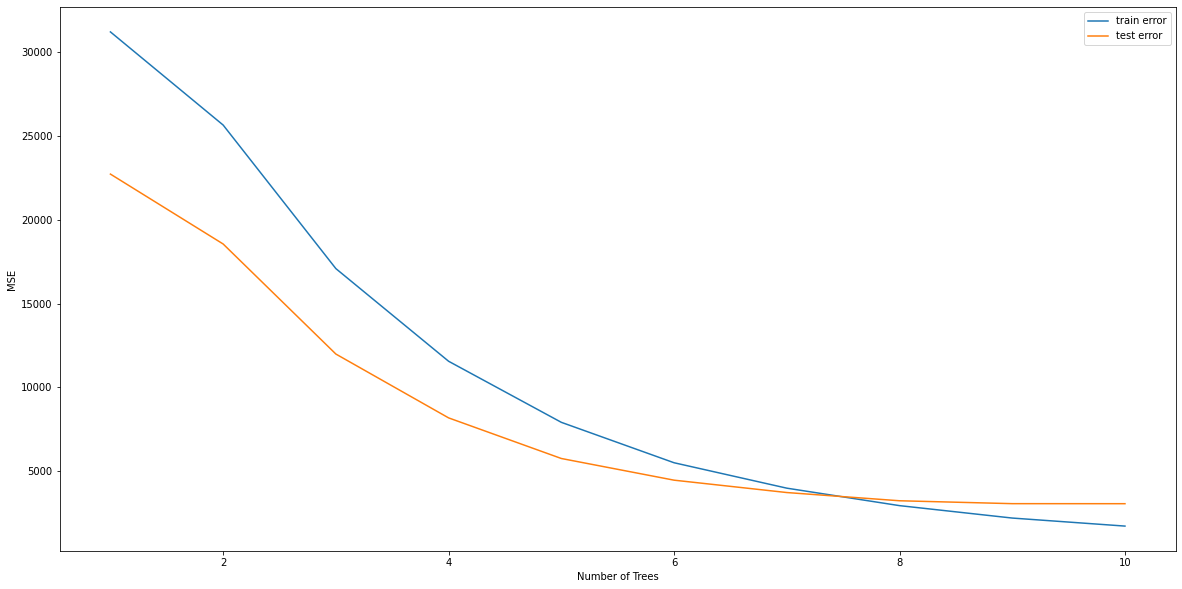

In [12]:
plt.figure(figsize=(20,10))
n_trees_plot(n_trees, train_errors_list[-1], test_errors_list[-1])

Выводы: 
- уменьшение ошибки видно на всем графике
- графики пересекаются в районе 7-8 деревьев, затем ошибка на тренировочной выборке начинает уменьшаться быстрее, а на тренировочной медленнее
- с увеличением деревьем при неизменном состоянии других параметров, модель переобучается

Теперь проанализируем зависимость ошибки от глубины дерева

In [13]:
# Число деревьев в ансамбле
n_trees = 15

# Максимальная глубина деревьев
max_depth = [_ for _ in range(1, 16)]

# Шаг
eta = 0.1

# для простоты примем коэффициенты равными 1
coefs = [1] * tree

train_errors_list = []
test_errors_list = []

for depth in max_depth:

    trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errors_list.append(train_errors[-1])
    test_errors_list.append(test_errors[-1])
    
    # Произведем оценку алгоритма
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')
    
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

Ошибка алгоритма из 15 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 3760.0193488371474
Ошибка алгоритма из 15 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 2902.745754575822
Ошибка алгоритма из 15 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 3154.1809953488446
Ошибка алгоритма из 15 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 2741.652597351319
Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 2557.297091089532
Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2832.1161266773097
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 1874.4475072735795
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 2786.1567078174317
Ошибка алгоритма из 15 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 1367.2201126490368
Ошибка алгоритма из 15 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3023.76

Визуализируем зависимость ошибки от глубины деревьев на графике

In [14]:
def depth_plot(max_depth, train_err, test_err):
    plt.xlabel('Max depth')
    plt.ylabel('MSE')
    plt.plot(max_depth, train_err, label='train error')
    plt.plot(max_depth, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

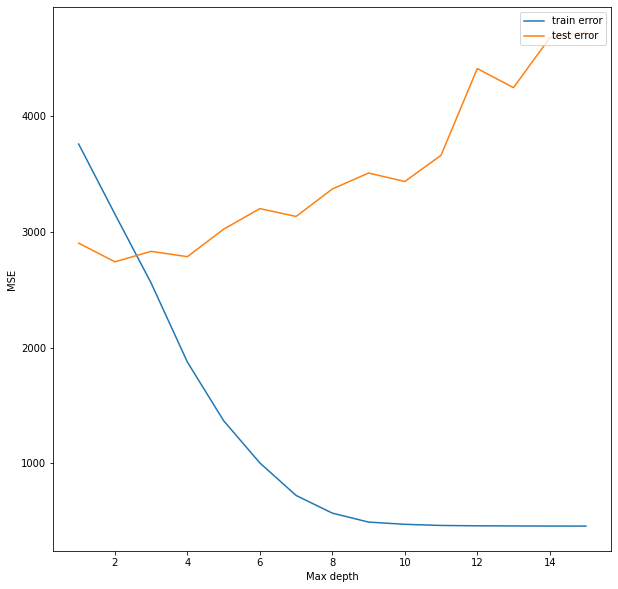

In [15]:
plt.figure(figsize=(10,10))
depth_plot(max_depth, train_errors_list, test_errors_list)

Выводы:
- значение ошибки на тренировочной выборке при увеличении глубины деревьев уменьшается и в районе глубины 10 выходит на плато
- значение ошибки на тестовой выборки увеличивается с увеличением глубины деревьев, это говорит о переобучении модели
- оптимальное значение глубины при данных параметрах - 3

In [16]:
# Число деревьев в ансамбле
n_trees = 15

# Максимальная глубина деревьев
max_depth = 4

# Шаг
eta = [1, 0.1, 0.01, 0.001, 0.0001, 1e-6]

# для простоты примем коэффициенты равными 1
coefs = [1] * tree

train_errors_list = []
test_errors_list = []

for alpha in eta:

    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, alpha)
    train_errors_list.append(train_errors[-1])
    test_errors_list.append(test_errors[-1])
    
    # Произведем оценку алгоритма
    
    train_prediction = gb_predict(X_train, trees, coefs, alpha)
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {alpha} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')
    
    test_prediction = gb_predict(X_test, trees, coefs, alpha)
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {alpha} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 1 на тренировочной выборке: 2379.66530611865
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 1 на тестовой выборке: 11441.122118875577
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 1874.4475072735795
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 2786.1567078174317
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.01 на тренировочной выборке: 22001.007673532447
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.01 на тестовой выборке: 15580.183761357093
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.001 на тренировочной выборке: 30128.57269514109
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.001 на тестовой выборке: 21884.16023901384
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.0001 на тренировочной выборке: 31095.194455701127
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.0001 на тестовой выборке: 

In [19]:
def alpha_plot(eta, train_err, test_err):
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.xlim(1, 1e-6)
    plt.plot(eta, train_err, label='train error')
    plt.plot(eta, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

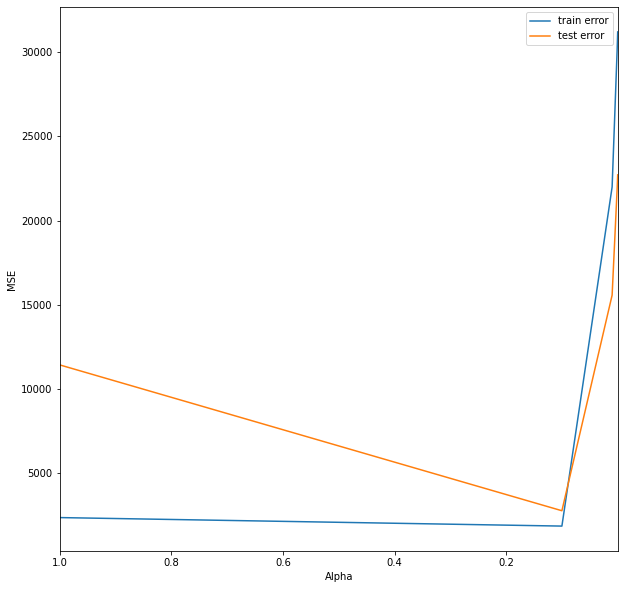

In [20]:
plt.figure(figsize=(10,10))
alpha_plot(eta, train_errors_list, test_errors_list)

Выводы:
- оптимальный шаг обучения равен примерно 0.1 при заданных параметрах
- слишком большой шаг, как и слишком маленький, увеличивает значение ошибки